In [ ]:
!cd ~/asl-ml-immersion && make bert_kernel

/bin/bash: line 0: cd: /root/asl-ml-immersion: No such file or directory


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


Num GPUs Available:  1


In [ ]:
pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 85.1 MB/s eta 0:00:00


In [ ]:
pip install tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [ ]:
df =pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df_spam = df[df['Category']=="spam"]


In [ ]:
df_ham=df[df["Category"]=="ham"]

In [ ]:
df_ham_down = df_ham.sample(df_spam.shape[0])
df_ham_down.shape

(747, 2)

In [ ]:
df_balc = pd.concat([df_spam,df_ham_down])

In [ ]:
df_balc["Category"].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [ ]:
df_balc['spam'] = df_balc["Category"].apply(lambda x :1 if x =="spam" else 0)

In [ ]:
pip install -U numpy


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balc['Message'],df_balc['spam'], stratify=df_balc['spam'])

In [ ]:
X_train.head(4)

3097    We walked from my moms. Right on stagwood pass...
3059    You are now unsubscribed all services. Get ton...
2386    Someone has contacted our dating service and e...
284                                               Okie...
Name: Message, dtype: object

**BERT**

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sent_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sent_embedding([
    "Nah I don't think he goes to usf, he lives around here though",
    "URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.77884036, -0.57414836, -0.9890554 , ..., -0.97273815,
        -0.6949255 ,  0.8704122 ],
       [-0.7222426 , -0.50519854, -0.85866725, ..., -0.5870076 ,
        -0.7139028 ,  0.73951554]], dtype=float32)>

**Build Model**

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#neural
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

TRAIN

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
35/35 [==============================] - 12s 354ms/step - loss: 0.3659 - accuracy: 0.8786
Epoch 2/10
35/35 [==============================] - 13s 356ms/step - loss: 0.3402 - accuracy: 0.8929
Epoch 3/10
35/35 [==============================] - 13s 356ms/step - loss: 0.3237 - accuracy: 0.8920
Epoch 4/10
35/35 [==============================] - 12s 357ms/step - loss: 0.3128 - accuracy: 0.8893
Epoch 5/10
35/35 [==============================] - 12s 355ms/step - loss: 0.2999 - accuracy: 0.9036
Epoch 6/10
35/35 [==============================] - 12s 352ms/step - loss: 0.2875 - accuracy: 0.9036
Epoch 7/10
35/35 [==============================] - 12s 351ms/step - loss: 0.2770 - accuracy: 0.9143
Epoch 8/10
35/35 [==============================] - 13s 368ms/step - loss: 0.2668 - accuracy: 0.9143
Epoch 9/10
35/35 [==============================] - 12s 354ms/step - loss: 0.2611 - accuracy: 0.9152
Epoch 10/10
35/35 [==============================] - 13s 358ms/step - loss: 0.2553 - accura

In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 326ms/step - loss: 0.2526 - accuracy: 0.9091


[0.25259944796562195, 0.9090909361839294]

In [ ]:
y_pred =model.predict(X_test)
y_pred=y_pred.flatten()

12/12 [==============================] - 5s 340ms/step


In [ ]:
y_pred

array([0.74958384, 0.0056737 , 0.9120152 , 0.9241413 , 0.981698  ,
       0.6032875 , 0.43228972, 0.816571  , 0.02085883, 0.7855226 ,
       0.31113982, 0.08039887, 0.92526734, 0.05144237, 0.9762057 ,
       0.08899085, 0.89226156, 0.94703233, 0.7745677 , 0.2867382 ,
       0.11305951, 0.04267418, 0.5117944 , 0.06884275, 0.9620911 ,
       0.03762368, 0.07804807, 0.81008077, 0.88823956, 0.15095644,
       0.9232105 , 0.48928744, 0.0163365 , 0.9738921 , 0.9381972 ,
       0.9762057 , 0.85694385, 0.8481332 , 0.9218048 , 0.89738137,
       0.9718169 , 0.03520356, 0.12508622, 0.89304954, 0.89380866,
       0.04490104, 0.05385777, 0.8166498 , 0.06042934, 0.771961  ,
       0.8174495 , 0.9444134 , 0.3221685 , 0.13413835, 0.23731351,
       0.06173332, 0.28817728, 0.75053   , 0.8184062 , 0.947653  ,
       0.08897445, 0.81132853, 0.02990786, 0.30204487, 0.01880733,
       0.9098427 , 0.8649658 , 0.7489236 , 0.02855205, 0.7501374 ,
       0.9346649 , 0.07177349, 0.8945672 , 0.03868591, 0.94797

In [ ]:
y_pred = np.where(y_pred>0.5 ,1,0)
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test,y_pred)
cm

array([[175,  12],
       [ 22, 165]])

Text(50.722222222222214, 0.5, 'actual')

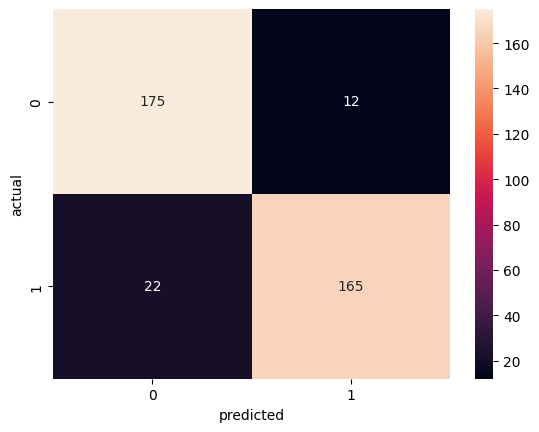

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel("predicted")
plt.ylabel("actual")

In [ ]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.80624294],
       [0.8370085 ],
       [0.75013745],
       [0.13398269],
       [0.06813984]], dtype=float32)